In [9]:
import os
import cv2
import numpy as np
import copy
from tqdm import tqdm
import requests
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision import transforms as TF
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import AdamW

from transformers import SegformerForSemanticSegmentation
from transformers import get_scheduler

from sklearn.metrics import jaccard_score
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from sklearn.metrics import jaccard_score

In [10]:


# Custom transform to invert colors for masks
class InvertMaskColors(object):
    def __call__(self, mask):
        if mask.mode != 'L':
            raise ValueError("Input mask should be in grayscale (L) mode")
        mask = TF.to_tensor(mask)
        mask = 1.0 - mask
        return TF.to_pil_image(mask)

# Custom dataset class
class BaseDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = [img for img in os.listdir(img_dir) if img.endswith(('.jpg', '.png'))]
        self.masks = [mask for mask in os.listdir(mask_dir) if mask.endswith(('.jpg', '.png'))]
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images[idx])
        image_basename = os.path.basename(image_path).split('.')[0]
        mask_path = os.path.join(self.mask_dir, image_basename + '.png')
        mask = Image.open(mask_path).convert('L')
        image = Image.open(image_path).convert('RGB')
        
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary format with 0 and 1 values
        mask = TF.to_tensor(mask)
        mask = (mask > 0).long()  # Threshold back to binary and convert to LongTensor

        return image, mask

# Mean IoU calculation function
def mean_iou(preds, labels, num_classes):
    preds_flat = preds.view(-1)
    labels_flat = labels.view(-1)

    if preds_flat.shape[0] != labels_flat.shape[0]:
        raise ValueError(f"Predictions and labels have mismatched shapes: "
                         f"{preds_flat.shape} vs {labels_flat.shape}")

    iou = jaccard_score(labels_flat.cpu().numpy(), preds_flat.cpu().numpy(),
                        average=None, labels=range(num_classes))

    return np.mean(iou)


In [11]:

# Define the appropriate transformations
image_transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((360, 640), interpolation=Image.NEAREST),
    InvertMaskColors(),  # Apply InvertMaskColors transform to masks
])


In [12]:

# Paths to the datasets
train_images_dataset_path = "/home/dlcompute/Yasin/lane-detection/datasets/bdd100k/images/100k/train"
train_masks_dataset_path = "/home/dlcompute/Yasin/lane-detection/datasets/bdd100k/labels/lane/masks/train"
val_images_dataset_path = "/home/dlcompute/Yasin/lane-detection/datasets/bdd100k/images/100k/val"
val_masks_dataset_path = "/home/dlcompute/Yasin/lane-detection/datasets/bdd100k/labels/lane/masks/val"

# Create the dataset
train_dataset = BaseDataset(img_dir=train_images_dataset_path,
                            mask_dir=train_masks_dataset_path,
                            image_transform=image_transform,
                            mask_transform=mask_transform)

valid_dataset = BaseDataset(img_dir=val_images_dataset_path,
                            mask_dir=val_masks_dataset_path,
                            image_transform=image_transform,
                            mask_transform=mask_transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=6)
valid_loader = DataLoader(valid_dataset, batch_size=12, shuffle=False, num_workers=6)


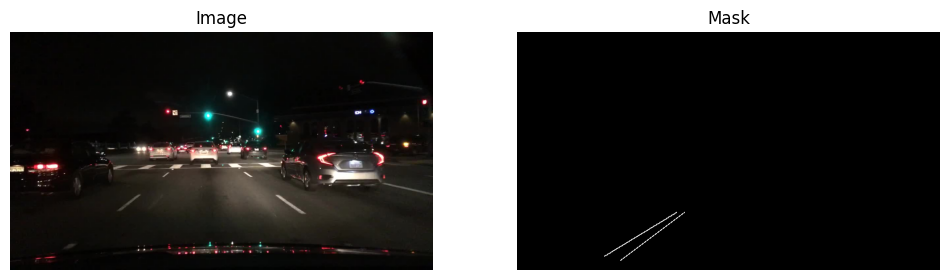

In [13]:
import matplotlib.pyplot as plt

# Function to visualize a sample
def show_sample(dataset, idx):
    image, mask = dataset[idx]
    images = [img for img in os.listdir(train_images_dataset_path) if img.endswith(('.jpg', '.png'))]
    image_pil = Image.open(os.path.join(train_images_dataset_path, images[idx]))
    
    # Reverse the normalization on image
    
    # Convert mask tensor to uint8 and then to PIL image for visualization
    mask = mask.byte()  # Convert to uint8
    mask_pil = TF.to_pil_image(mask)

    # Display the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_pil, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.show()

# Load a sample from the train dataset
show_sample(train_dataset, 0)


In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b2-finetuned-ade-512-512')
model.config.num_labels = 2  # Replace with the actual number of classes


In [ ]:
# Check for CUDA acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the learning rate scheduler
num_epochs = 30
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Placeholder for best mean IoU and best model weights
best_iou = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for batch in train_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()  # Ensure masks are LongTensors

        # Remove the channel dimension from the masks tensor
        masks = masks.squeeze(1)  # This changes the shape from [batch, 1, H, W] to [batch, H, W]
        optimizer.zero_grad()

        # Pass pixel_values and labels to the model
        outputs = model(pixel_values=images, labels=masks,return_dict=True)
        
        loss = outputs["loss"]
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
        
        train_iterator.set_postfix(loss=loss.item())
    
    # Evaluation loop for each epoch
    model.eval()
    total_iou = 0
    num_batches = 0
    valid_iterator = tqdm(valid_loader, desc="Validation", unit="batch")
    for batch in valid_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()
    
        with torch.no_grad():
            # Get the logits from the model and apply argmax to get the predictions
            outputs = model(pixel_values=images,return_dict=True)
            outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            preds = torch.unsqueeze(preds, dim=1)

        preds = preds.view(-1)
        masks = masks.view(-1)
    
        # Compute IoU
        iou = mean_iou(preds, masks, model.config.num_labels)
        total_iou += iou
        num_batches += 1
        valid_iterator.set_postfix(mean_iou=iou)
    
    epoch_iou = total_iou / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} - Mean IoU: {epoch_iou:.4f}")

    # Check for improvement
    if epoch_iou > best_iou:
        print(f"Validation IoU improved from {best_iou:.4f} to {epoch_iou:.4f}")
        best_iou = epoch_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'best_model.pth')

# After all epochs, load the best model weights - optional
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded the best model weights!")